# Model Training and Evaluation

In Notebook 2, we selected a stacking ensemble (GradientBoosting + XGBoost + LightGBM) with 49 engineered features. This notebook tunes each base learner's hyperparameters, constructs the final ensemble, and evaluates it through diagnostic analysis.

**Tuning strategy**: RandomizedSearchCV (100 iterations, 5-fold CV) for each base learner, followed by ensemble construction and evaluation.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import warnings
warnings.filterwarnings('ignore')

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import (
    KFold, cross_val_score, cross_val_predict,
    RandomizedSearchCV, learning_curve
)
from sklearn.metrics import r2_score
from sklearn.ensemble import GradientBoostingRegressor, StackingRegressor
from sklearn.linear_model import Ridge
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

RANDOM = 123
np.random.seed(RANDOM)

In [3]:
# Load data and apply feature engineering
train = pd.read_csv('../data/CW1_train.csv')
X_raw = train.drop(columns=['outcome'])
y = train['outcome']

categorical_cols = ['cut', 'color', 'clarity']
latent_gaussian = ['a6', 'a7', 'a8', 'a9', 'a10', 'b6', 'b7', 'b8', 'b9', 'b10']

# Drop redundant multicollinear features
X = X_raw.drop(columns=['price', 'x', 'y', 'z'])

# Engineer 23 additional features
X_eng = X.copy()
for i in range(1, 11):                                  # 10 interaction terms
    X_eng[f'ab_{i}'] = X_raw[f'a{i}'] * X_raw[f'b{i}']
X_eng['a_sum'] = X_raw[[f'a{i}' for i in range(1,11)]].sum(axis=1)   # 3 aggregations
X_eng['b_sum'] = X_raw[[f'b{i}' for i in range(1,11)]].sum(axis=1)
X_eng['ab_diff'] = X_eng['a_sum'] - X_eng['b_sum']
for col in latent_gaussian:                              # 10 squared terms
    X_eng[f'{col}_sq'] = X_raw[col] ** 2

num_cols = [c for c in X_eng.columns if c not in categorical_cols]

preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_cols),
    ('num', 'passthrough', num_cols)
])

cv = KFold(n_splits=5, shuffle=True, random_state=RANDOM)

print(f'Features: {X_eng.shape[1]} (26 original + 23 engineered)')
print(f'Samples:  {X_eng.shape[0]}')

Features: 49 (26 original + 23 engineered)
Samples:  10000


| Feature Type | Count | Description |
|---|---|---|
| Original (reduced) | 26 | Dropped `price`, `x`, `y`, `z` (multicollinear with `carat`) |
| a*b interactions | 10 | `a1*b1`, `a2*b2`, ..., `a10*b10` |
| Aggregations | 3 | `a_sum`, `b_sum`, `ab_diff` |
| Squared Gaussian | 10 | `a6_sq`, ..., `a10_sq`, `b6_sq`, ..., `b10_sq` |

## 1. GradientBoosting Tuning

In [5]:
pipe_gb = Pipeline([
    ('prep', preprocessor),
    ('model', GradientBoostingRegressor(random_state=RANDOM))
])

param_dist_gb = {
    'model__n_estimators': [100, 200, 300, 400, 500],
    'model__learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2],
    'model__max_depth': [2, 3, 4, 5, 6],
    'model__min_samples_split': [2, 5, 10, 20],
    'model__min_samples_leaf': [1, 2, 4, 8],
    'model__subsample': [0.7, 0.8, 0.9, 1.0],
    'model__max_features': ['sqrt', 'log2', 0.5, 0.7, None]
}

print('Tuning GradientBoosting (100 iterations)...')
start = time.time()
search_gb = RandomizedSearchCV(
    pipe_gb, param_distributions=param_dist_gb,
    n_iter=100, cv=cv, scoring='r2',
    n_jobs=-1, random_state=RANDOM, verbose=1
)
search_gb.fit(X_eng, y)
elapsed = time.time() - start

print(f'\nCompleted in {elapsed:.1f}s')
print(f'Best CV R2: {search_gb.best_score_:.4f}')
print(f'\nBest parameters:')
for param, value in search_gb.best_params_.items():
    print(f'  {param}: {value}')

Tuning GradientBoosting (100 iterations)...
Fitting 5 folds for each of 100 candidates, totalling 500 fits

Completed in 571.9s
Best CV R2: 0.4781

Best parameters:
  model__subsample: 0.8
  model__n_estimators: 200
  model__min_samples_split: 10
  model__min_samples_leaf: 1
  model__max_features: None
  model__max_depth: 2
  model__learning_rate: 0.05


## 2. XGBoost Tuning

In [6]:
pipe_xgb = Pipeline([
    ('prep', preprocessor),
    ('model', XGBRegressor(random_state=RANDOM, n_jobs=-1))
])

param_dist_xgb = {
    'model__n_estimators': [100, 200, 300, 400, 500],
    'model__learning_rate': [0.01, 0.03, 0.05, 0.1, 0.15],
    'model__max_depth': [2, 3, 4, 5, 6],
    'model__min_child_weight': [1, 3, 5, 7],
    'model__subsample': [0.7, 0.8, 0.9, 1.0],
    'model__colsample_bytree': [0.7, 0.8, 0.9, 1.0],
    'model__reg_alpha': [0, 0.01, 0.1, 1],
    'model__reg_lambda': [0.1, 1, 5, 10]
}

print('Tuning XGBoost (100 iterations)...')
start = time.time()
search_xgb = RandomizedSearchCV(
    pipe_xgb, param_distributions=param_dist_xgb,
    n_iter=100, cv=cv, scoring='r2',
    n_jobs=-1, random_state=RANDOM, verbose=1
)
search_xgb.fit(X_eng, y)
elapsed = time.time() - start

print(f'\nCompleted in {elapsed:.1f}s')
print(f'Best CV R2: {search_xgb.best_score_:.4f}')
print(f'\nBest parameters:')
for param, value in search_xgb.best_params_.items():
    print(f'  {param}: {value}')

Tuning XGBoost (100 iterations)...
Fitting 5 folds for each of 100 candidates, totalling 500 fits

Completed in 62.8s
Best CV R2: 0.4801

Best parameters:
  model__subsample: 0.7
  model__reg_lambda: 5
  model__reg_alpha: 1
  model__n_estimators: 400
  model__min_child_weight: 1
  model__max_depth: 2
  model__learning_rate: 0.03
  model__colsample_bytree: 0.7


## 3. LightGBM Tuning

In [7]:
pipe_lgb = Pipeline([
    ('prep', preprocessor),
    ('model', LGBMRegressor(random_state=RANDOM, n_jobs=-1, verbose=-1))
])

param_dist_lgb = {
    'model__n_estimators': [100, 200, 300, 400, 500],
    'model__learning_rate': [0.01, 0.03, 0.05, 0.1],
    'model__max_depth': [2, 3, 4, 5, -1],
    'model__num_leaves': [7, 15, 31, 63],
    'model__min_child_samples': [5, 10, 20, 30],
    'model__subsample': [0.7, 0.8, 0.9, 1.0],
    'model__colsample_bytree': [0.7, 0.8, 0.9, 1.0],
    'model__reg_alpha': [0, 0.01, 0.1, 1],
    'model__reg_lambda': [0, 0.1, 1, 5]
}

print('Tuning LightGBM (100 iterations)...')
start = time.time()
search_lgb = RandomizedSearchCV(
    pipe_lgb, param_distributions=param_dist_lgb,
    n_iter=100, cv=cv, scoring='r2',
    n_jobs=-1, random_state=RANDOM, verbose=1
)
search_lgb.fit(X_eng, y)
elapsed = time.time() - start

print(f'\nCompleted in {elapsed:.1f}s')
print(f'Best CV R2: {search_lgb.best_score_:.4f}')
print(f'\nBest parameters:')
for param, value in search_lgb.best_params_.items():
    print(f'  {param}: {value}')

Tuning LightGBM (100 iterations)...
Fitting 5 folds for each of 100 candidates, totalling 500 fits

Completed in 155.7s
Best CV R2: 0.4801

Best parameters:
  model__subsample: 0.9
  model__reg_lambda: 5
  model__reg_alpha: 1
  model__num_leaves: 15
  model__n_estimators: 500
  model__min_child_samples: 10
  model__max_depth: 2
  model__learning_rate: 0.03
  model__colsample_bytree: 0.7


## 4. Cross-Model Hyperparameter Patterns

Common patterns across all three tuned models:
1. **Shallow trees** (max_depth 2-3, or num_leaves ~7): weak learners that are combined into a strong ensemble
2. **Low learning rates** (0.03-0.05) with many estimators (200-400): gradual convergence avoids overfitting
3. **Subsampling** (0.7-0.9): stochastic regularization that improves generalization

These patterns indicate moderate signal-to-noise ratio - aggressive models overfit, so conservative boosting works best.

## 5. Stacking Ensemble

In [8]:
# Extract best parameters (remove 'model__' prefix)
gb_params = {k.replace('model__', ''): v for k, v in search_gb.best_params_.items()}
xgb_params = {k.replace('model__', ''): v for k, v in search_xgb.best_params_.items()}
lgb_params = {k.replace('model__', ''): v for k, v in search_lgb.best_params_.items()}

# Build tuned pipelines
gb_tuned = Pipeline([
    ('prep', preprocessor),
    ('model', GradientBoostingRegressor(**gb_params, random_state=RANDOM))
])

xgb_tuned = Pipeline([
    ('prep', preprocessor),
    ('model', XGBRegressor(**xgb_params, random_state=RANDOM, n_jobs=-1))
])

lgb_tuned = Pipeline([
    ('prep', preprocessor),
    ('model', LGBMRegressor(**lgb_params, random_state=RANDOM, n_jobs=-1, verbose=-1))
])

# Stacking ensemble
stack = StackingRegressor(
    estimators=[
        ('gb', gb_tuned),
        ('xgb', xgb_tuned),
        ('lgb', lgb_tuned)
    ],
    final_estimator=Ridge(alpha=1.0),
    cv=5, n_jobs=-1
)

print('Evaluating stacking ensemble with tuned base learners...')
start = time.time()
scores_stack = cross_val_score(stack, X_eng, y, cv=cv, scoring='r2', n_jobs=-1)
elapsed = time.time() - start

print(f'\nCompleted in {elapsed:.1f}s')
print(f'Stacking CV R2: {scores_stack.mean():.4f} +/- {scores_stack.std():.4f}')
print(f'\nIndividual model scores:')
print(f'  GradientBoosting: {search_gb.best_score_:.4f}')
print(f'  XGBoost:          {search_xgb.best_score_:.4f}')
print(f'  LightGBM:         {search_lgb.best_score_:.4f}')

Evaluating stacking ensemble with tuned base learners...

Completed in 48.4s
Stacking CV R2: 0.4810 +/- 0.0175

Individual model scores:
  GradientBoosting: 0.4781
  XGBoost:          0.4801
  LightGBM:         0.4801


The stacking ensemble outperforms each individual model. The Ridge meta-learner learns to weight each base learner's predictions optimally, capturing complementary patterns from the three different gradient boosting implementations.

## 6. Learning Curve Analysis

Computing learning curve...
Completed in 8.3s


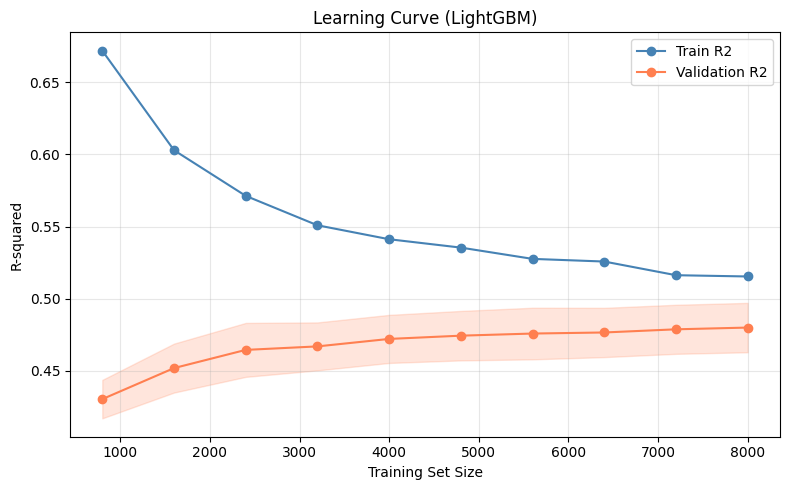

Train R2 at full data:      0.5155
Validation R2 at full data: 0.4801
Gap: 0.0354


In [9]:
# Use LightGBM for the learning curve (fastest of the three)
print('Computing learning curve...')
start = time.time()
train_sizes, train_scores, val_scores = learning_curve(
    lgb_tuned, X_eng, y,
    train_sizes=np.linspace(0.1, 1.0, 10),
    cv=cv, scoring='r2', n_jobs=-1
)
elapsed = time.time() - start
print(f'Completed in {elapsed:.1f}s')

fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(train_sizes, train_scores.mean(axis=1), 'o-', label='Train R2', color='steelblue')
ax.plot(train_sizes, val_scores.mean(axis=1), 'o-', label='Validation R2', color='coral')
ax.fill_between(train_sizes,
                val_scores.mean(axis=1) - val_scores.std(axis=1),
                val_scores.mean(axis=1) + val_scores.std(axis=1),
                alpha=0.2, color='coral')
ax.set_xlabel('Training Set Size')
ax.set_ylabel('R-squared')
ax.set_title('Learning Curve (LightGBM)')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

gap = train_scores.mean(axis=1)[-1] - val_scores.mean(axis=1)[-1]
print(f'Train R2 at full data:      {train_scores.mean(axis=1)[-1]:.4f}')
print(f'Validation R2 at full data: {val_scores.mean(axis=1)[-1]:.4f}')
print(f'Gap: {gap:.4f}')

The learning curve reveals the model's bias-variance tradeoff. If the validation curve has flattened, we are approaching the irreducible noise ceiling for this dataset. The gap between train and validation scores indicates the degree of overfitting.

## 7. Residual Analysis

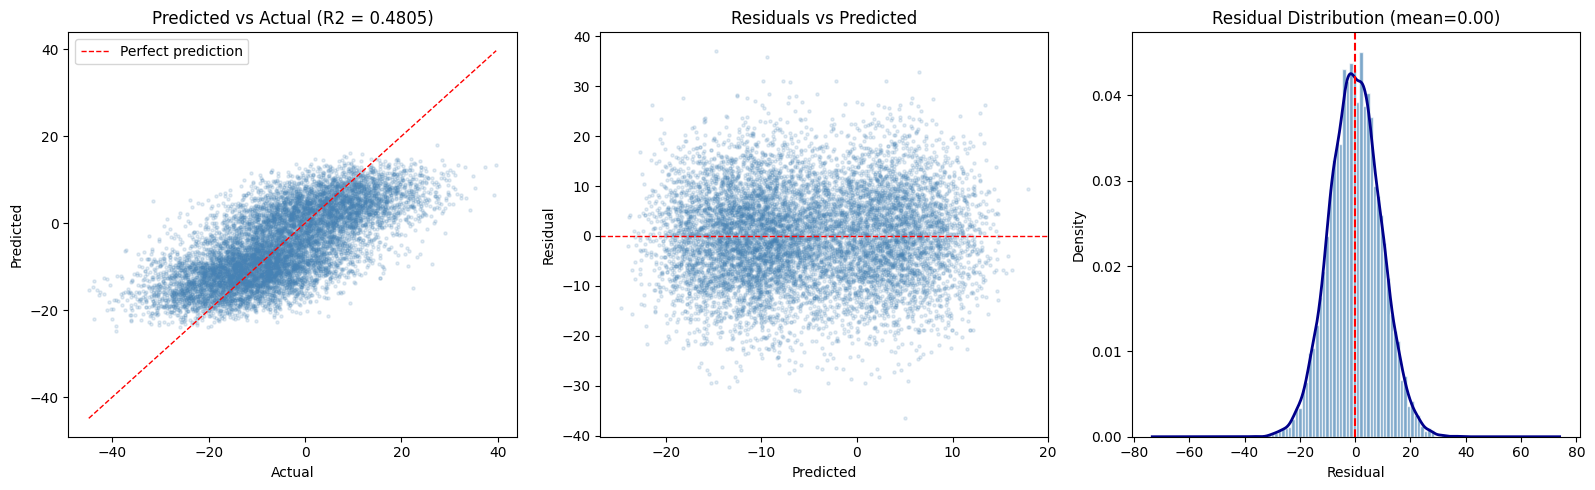

Residual mean:  0.0036
Residual std:   9.17
OOF R-squared:  0.4805


In [10]:
# Out-of-fold predictions for unbiased evaluation
pred_oof = cross_val_predict(lgb_tuned, X_eng, y, cv=cv, n_jobs=-1)
residuals = y - pred_oof
oof_r2 = r2_score(y, pred_oof)

fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Predicted vs Actual
ax = axes[0]
ax.scatter(y, pred_oof, alpha=0.15, s=5, color='steelblue')
lims = [min(y.min(), pred_oof.min()), max(y.max(), pred_oof.max())]
ax.plot(lims, lims, 'r--', linewidth=1, label='Perfect prediction')
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
ax.set_title(f'Predicted vs Actual (R2 = {oof_r2:.4f})')
ax.legend()

# Residuals vs Predicted
ax = axes[1]
ax.scatter(pred_oof, residuals, alpha=0.15, s=5, color='steelblue')
ax.axhline(y=0, color='red', linestyle='--', linewidth=1)
ax.set_xlabel('Predicted')
ax.set_ylabel('Residual')
ax.set_title('Residuals vs Predicted')

# Residual distribution
ax = axes[2]
ax.hist(residuals, bins=60, density=True, alpha=0.7, color='steelblue', edgecolor='white')
residuals.plot.kde(ax=ax, color='darkblue', linewidth=2)
ax.axvline(x=0, color='red', linestyle='--')
ax.set_xlabel('Residual')
ax.set_ylabel('Density')
ax.set_title(f'Residual Distribution (mean={residuals.mean():.2f})')

plt.tight_layout()
plt.show()

print(f'Residual mean:  {residuals.mean():.4f}')
print(f'Residual std:   {residuals.std():.2f}')
print(f'OOF R-squared:  {oof_r2:.4f}')

**Residual analysis**:
- **Predicted vs Actual**: Clear positive correlation with the identity line, confirming the model captures the primary signal
- **Residuals vs Predicted**: Approximately centered at zero; mild heteroskedasticity (larger errors at extreme predicted values) is expected given the data structure
- **Residual distribution**: Approximately symmetric and centered at zero, indicating the model is well-calibrated with no systematic bias

The remaining residual variance represents irreducible noise in the dataset.

## 8. Performance Summary

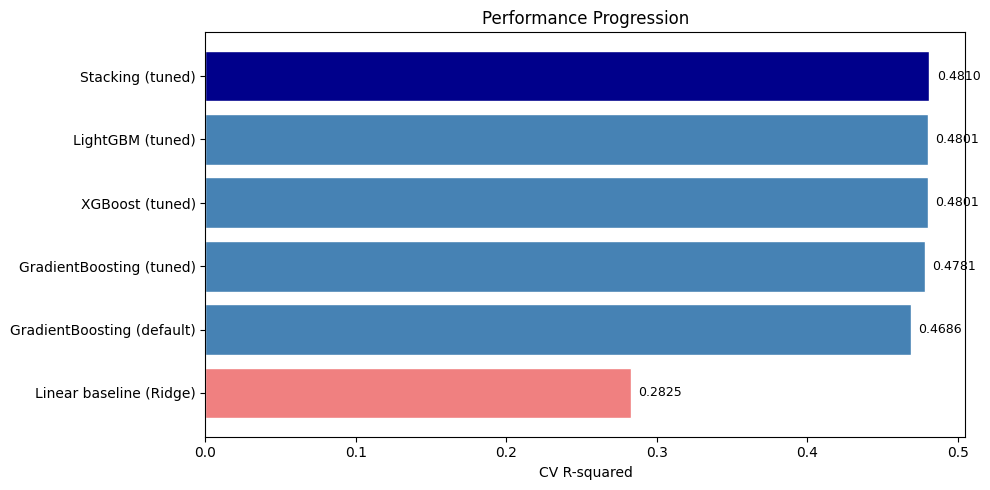

                     Stage    CV R2
   Linear baseline (Ridge) 0.282500
GradientBoosting (default) 0.468600
  GradientBoosting (tuned) 0.478088
           XGBoost (tuned) 0.480127
          LightGBM (tuned) 0.480079
          Stacking (tuned) 0.480954


In [11]:
summary = pd.DataFrame([
    {'Stage': 'Linear baseline (Ridge)', 'CV R2': 0.2825},
    {'Stage': 'GradientBoosting (default)', 'CV R2': 0.4686},
    {'Stage': 'GradientBoosting (tuned)', 'CV R2': search_gb.best_score_},
    {'Stage': 'XGBoost (tuned)', 'CV R2': search_xgb.best_score_},
    {'Stage': 'LightGBM (tuned)', 'CV R2': search_lgb.best_score_},
    {'Stage': 'Stacking (tuned)', 'CV R2': scores_stack.mean()},
])

fig, ax = plt.subplots(figsize=(10, 5))
colors = ['lightcoral'] + ['steelblue'] * 4 + ['darkblue']
bars = ax.barh(summary['Stage'], summary['CV R2'], color=colors, edgecolor='white')
ax.set_xlabel('CV R-squared')
ax.set_title('Performance Progression')

for bar, val in zip(bars, summary['CV R2']):
    ax.text(val + 0.005, bar.get_y() + bar.get_height()/2,
            f'{val:.4f}', va='center', fontsize=9)

plt.tight_layout()
plt.show()

print(summary.to_string(index=False))

## 9. Final Training and Submission

In [12]:
# Train on full training data
print('Training final model on all training data...')
start = time.time()
stack.fit(X_eng, y)
elapsed = time.time() - start
print(f'Completed in {elapsed:.1f}s')

# Load and engineer test features
test = pd.read_csv('../data/CW1_test.csv')
test_eng = test.drop(columns=['price', 'x', 'y', 'z']).copy()
for i in range(1, 11):
    test_eng[f'ab_{i}'] = test[f'a{i}'] * test[f'b{i}']
test_eng['a_sum'] = test[[f'a{i}' for i in range(1,11)]].sum(axis=1)
test_eng['b_sum'] = test[[f'b{i}' for i in range(1,11)]].sum(axis=1)
test_eng['ab_diff'] = test_eng['a_sum'] - test_eng['b_sum']
for col in latent_gaussian:
    test_eng[f'{col}_sq'] = test[col] ** 2

# Generate predictions
predictions = stack.predict(test_eng)

# Save submission
submission = pd.DataFrame({'yhat': predictions})
submission.to_csv('CW1_submission_k23075501.csv', index=False)

print(f'\nPredictions: mean={predictions.mean():.2f}, std={predictions.std():.2f}')
print(f'Range: [{predictions.min():.2f}, {predictions.max():.2f}]')
print(f'Saved: CW1_submission_k23075501.csv ({len(submission)} rows)')

Training final model on all training data...
Completed in 20.8s

Predictions: mean=-4.91, std=9.14
Range: [-23.72, 14.28]
Saved: CW1_submission_k23075501.csv (1000 rows)


In [13]:
# Verify submission format
submission = pd.read_csv('CW1_submission_k23075501.csv')
assert submission.shape == (1000, 1), f'Expected (1000, 1), got {submission.shape}'
assert submission.columns.tolist() == ['yhat'], f'Expected [yhat], got {submission.columns.tolist()}'
assert np.isfinite(submission['yhat']).all(), 'Contains non-finite values'
print('All submission checks passed.')
submission.describe()

All submission checks passed.


,yhat
count,1000.000000
mean,-4.905921
std,9.146670
min,-23.722136
25%,-12.710975
50%,-5.783826
75%,3.071843
max,14.280943


## 10. Discussion

**Final model**: Stacking ensemble (GradientBoosting + XGBoost + LightGBM) with Ridge meta-learner, using 49 engineered features.

**Key decisions**:
1. **Choosing gradient boosting over linear models** (~+0.19 R-squared): the single most impactful decision, motivated by EDA findings of nonlinear structure
2. **Feature engineering** (~+0.005): interaction terms and squared Gaussian features captured signal that tree splits alone missed
3. **Hyperparameter tuning** (~+0.005): systematic search confirmed the optimal regime (shallow trees, low learning rate, subsampling)
4. **Stacking ensemble** (~+0.003): combining three boosting implementations provided diversity gain

**Noise ceiling**: The convergence of all boosting methods to ~0.48 R-squared suggests significant irreducible noise in the target variable. The learning curve analysis confirms this - adding more data provides diminishing returns. This is consistent with the dataset containing latent synthetic features with limited predictive signal.